In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.stats.mstats import pearsonr as corr
from math import pi
from functools import reduce
from operator import mul
from math import log

In [8]:
np.random.seed(42)
dist = [np.random.normal(0, 5, 10000), np.random.normal(-2, 3, 10000)]
general = np.hstack(dist)

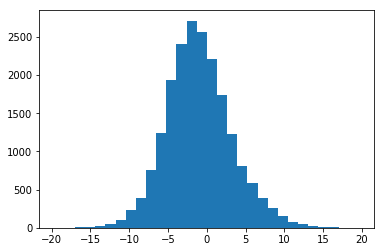

In [9]:
plot = plt.hist(general, bins=30)

In [10]:
def f_norm(mean, std):
    return lambda x: np.exp(-(x - mean)**2 / (2 * std ** 2)) / (std * (2 * pi) ** 0.5)


def llf(sample, f0, f1):
    return np.log(f1(sample) / f0(sample))


def sprt(general, f0, f1, alpha, beta, num_iterations=10000):
    c0 = np.log(beta / (1 - alpha))
    c1 = np.log((1 - beta) / alpha)
    results = []
    for i in range(num_iterations):
        sample = np.array([])
        while True:
            sample = np.hstack([sample, np.random.choice(general, 1)])
            Z = llf(sample, f0, f1).sum()
            if Z < c0:
                results.append((0, len(sample)))
                break
            elif Z > c1:
                results.append((1, len(sample)))
                break
    return results


def w(x, y):
    return (1 - x) * np.log((1 - x) / y) + x * np.log(x / (1 - y))


def E(f, mean0, mean1, std):
    func = lambda x: f(x) * (-(x - mean1) ** 2 + (x - mean0) ** 2) / (2 * std ** 2)
    return integrate.quad(func, -np.inf, np.inf)[0]


def estimation(alpha, beta, mean0, mean1, std, f0, f1):
    return -w(alpha, beta) / E(f0, mean0, mean1, std), w(beta, alpha) / E(f1, mean0, mean1, std)

**Choosing the hypothesises**

We will choose the normal distribution with the general sample's mean and std as the null hypothesis, and the normal distribution with the mean of some subsample of the general sample and the correct std as the alternative hypothesis:

In [14]:
mean0 = general.mean()
mean1 = np.random.choice(general, 1000).mean()
std = general.std()

f0 = f_norm(mean0, std)
f1 = f_norm(mean1, std)
alpha = 0.05
beta = 0.1

mean0, mean1, std

(-0.9850388788237345, -1.1971064004469163, 4.247760825015384)

**Run SPRT 1000 times**

In [24]:
%%time

result = pd.DataFrame(sprt(general, f0, f1, alpha, beta, num_iterations=1000), columns=['result', 'len_sample'])

Wall time: 2min 54s


**Analyzing results**

Results of the tests, 0 stands for the 0 hypothesis (correct one), and 1 stands for 1 hypotesis (incorrect):

In [25]:
result.result.value_counts()

0    954
1     46
Name: result, dtype: int64

Since we now that the null hypothesis is correct (well, pretty close to be correct), we can see that the propability of type-I error is very close to the one we originally set (alpha=0.05) - after the run of a 1000 tests we ended up with this probability equal to 0.046.

**Average number of observations for both results:**

In [26]:
result[result.result == 0].len_sample.mean(), result[result.result == 1].len_sample.mean()

(1554.9916142557652, 1916.608695652174)

**Expected number of observations:**

In [27]:
estimation(alpha, beta, mean0, mean1, 5, f0, f1)

(2217.1356839686136, 2641.8348285418524)

The resulting numbers of observations are relatively close to the expected ones (no to close because of only 1000 runs of the SPRT)